# Common imports

In [1]:
import joblib
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Dataset loading

In [2]:
# Some necessary constants
ROOT_PATH = "drive/MyDrive/Навчання/6 семестр/Курсова"
DATASET_PATH = f"{ROOT_PATH}/lyrics-data"
MODELS_PATH = f"{ROOT_PATH}/saved-models"

In [3]:
def load_dataset(dataset_dir):
    """
    Loads dataset from given directory.
    Asserts that all data is split in folders named after respective class name.
    """

    import os

    for dir in os.listdir(dataset_dir):
        dir_path = os.path.join(dataset_dir, dir)
        for filename in tqdm(os.listdir(dir_path)):
            file_path = os.path.join(dir_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                if text.startswith("ERROR"):
                    continue
                yield text.replace("\n", " "), dir

In [ ]:
texts, labels = [], []
for text, label in load_dataset(DATASET_PATH):
    texts.append(text)
    labels.append(label)

In [ ]:
# Dumping dataset python objects for faster retrieval
with open(f"{MODELS_PATH}/dataset.pickle", "wb") as file:
    pickle.dump({"texts": texts, "labels": labels}, file)

In [32]:
# Loading dataset as python object
with open(f"{MODELS_PATH}/dataset.pickle", "rb") as file:
    d = pickle.load(file)
    texts, labels = d["texts"], d["labels"].to_list()

In [ ]:
# Plotting classes distribution
pd.Series(labels).hist()

# Input data preprocessing and transformation

In [23]:
import nltk
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.WordNetLemmatizer()

In [ ]:
# Function for cleaning and preprocessing input data with the following steps:
# - Transforming to lowercase
# - Tokenizing by word
# - Removing stopwords
# - Remaining only words that are alphabetic
# - Lemmatazing words


def preprocess(text):
    lower_case = text.lower()
    tokens = nltk.word_tokenize(lower_case)
    without_stopwords = [w for w in tokens if w not in stopwords]
    alphabetic_only = [w for w in without_stopwords if w.isalpha()]
    lemmatized = [lemmatizer.lemmatize(w) for w in alphabetic_only]
    return lemmatized

In [89]:
# Creating preprocessed texts for future use and getting the length of the longest text

processed_texts = [preprocess(t) for t in texts]
max_len = len(max(processed_texts, key=len))

In [35]:
le = LabelEncoder()
y = le.fit_transform(labels)
y

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
# Converting labels to numerical values
le = LabelEncoder()
y = le.fit_transform(labels)
y_one_hot = to_categorical(y)

In [91]:
# Converting texts to TF-IDF representation

tf_idf = TfidfVectorizer(analyzer=preprocess)
X_tf_idf = tf_idf.fit_transform(texts).toarray()

X_tf_idf_train, X_tf_idf_test, y_train, y_test = train_test_split(
    X_tf_idf, y, test_size=0.25, random_state=42
)

In [ ]:
# Converting texts to one hot encodings

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_sequences(processed_texts)
vocabulary_size = len(tokenizer.index_docs) + 1

X_one_hot = np.array(
    [
        [tokenizer.index_docs[w] for w in t] + ([0] * (max_len - len(t)))
        for t in processed_texts
    ]
)

X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(
    X_one_hot, y_one_hot, test_size=0.25, random_state=42
)

## Word cloud

In [ ]:
# Creating a word cloud of all tokens

from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([" ".join(t) for t in processed_texts])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Utilities

In [ ]:
# Simple utility function to evaluate estimator

import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from matplotlib import pyplot as plt


def evaluate_estimator(estimator, X, y, preds_one_hot=False, history=None):
    preds_one_hot = (
        estimator.predict(X) if preds_one_hot else estimator.predict_proba(X_test)
    )
    preds = np.argmax(preds_one_hot, axis=1)
    y_binazed = LabelBinarizer().fit_transform(y)

    fig, ax = plt.subplots(figsize=(6, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i in range(4):
        display = RocCurveDisplay.from_predictions(
            y_binazed[:, i],
            preds_one_hot[:, i],
            name=f"{le.classes_[i].title()} vs the rest",
            color=next(colors),
            ax=ax,
        )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    plt.show()

    clf_report = metrics.classification_report(
        y, preds, target_names=le.classes_, output_dict=True
    )
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

    disp = metrics.ConfusionMatrixDisplay.from_predictions(
        y, preds, display_labels=le.classes_
    )
    plt.show()

    if history is None:
        return

    loss = history["loss"]
    val_loss = history["val_loss"]
    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    # Plotting the loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "r", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plotting the accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, "r", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Naive Bayes

In [ ]:
naive_bayers_cv_model_path = f"{MODELS_PATH}/naive-bayes-grid-search-cv.pkl"

In [ ]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

param_grid = {"var_smoothing": [1e-9, 1e-8, 1e-7]}

nb_cv = GridSearchCV(naive_bayes, param_grid)
nb_cv.fit(X_train, y_train)

joblib.dump(nb_cv, naive_bayers_cv_model_path)

In [ ]:
cv = joblib.load(naive_bayers_cv_model_path)

best_nb = cv.best_estimator_

evaluate_estimator(best_nb, X_tf_idf_test, y_test)

NameError: name 'evaluate_estimator' is not defined

In [ ]:
cv.best_params_

{'var_smoothing': 1e-07}

# Random forest

In [ ]:
random_forest_cv_model_path = f"{MODELS_PATH}/random-forest-grid-search-cv.pkl"

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_cv = GridSearchCV(rf, param_grid)
rf_cv.fit(X_train, y_train)

joblib.dump(rf_cv, random_forest_cv_model_path)

In [ ]:
rf_cv = joblib.load(random_forest_cv_model_path)

best_rf = rf_cv.best_estimator_

evaluate_estimator(best_rf, X_tf_idf_test, y_test)

NameError: name 'evaluate_estimator' is not defined

In [ ]:
rf_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_binazed_test = label_binarizer.transform(y_test)
y_binazed_test.shape

In [ ]:
# @title
feat_importances = pd.Series(
    best_rf.feature_importances_, index=tf_idf.get_feature_names_out()
)
feat_importances.nlargest(20).plot(kind="bar", figsize=(10, 10))
plt.title("Top 20 important features")
plt.show()

# Dense Neural Networks

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout

In [ ]:
def create_dnn(input_shape, units, optimizer="adam"):
    model = Sequential(
        [
            Dense(units[0], activation="relu", input_shape=(input_shape,)),
            Dropout(0.3),
            Dense(units[1], activation="relu"),
            Dropout(0.3),
            Dense(le.classes_.shape[0], activation="softmax"),
        ]
    )

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    print(model.summary())

    return model

## Using TF-IDF

In [ ]:
tf_idf_dnn_binary_path = f"{MODELS_PATH}/tf-idf-dnn-binary.h5"
tf_idf_dnn_history_path = f"{MODELS_PATH}/tf-idf-dnn-history.pickle"

In [ ]:
tfidf_dnn_model = create_dnn(X_tf_idf_train.shape[1], [128, 64])

history = tfidf_dnn_model.fit(
    X_tf_idf_train, y_train_one_hot, epochs=8, batch_size=32, validation_split=0.25
)

tfidf_dnn_model.save(tf_idf_dnn_binary_path)
with open(tf_idf_dnn_history_path, "wb") as file:
    pickle.dump(history.history, file)

In [ ]:
model = load_model(tf_idf_dnn_binary_path)
with open(tf_idf_dnn_history_path, "rb") as file:
    history = pickle.load(file)

evaluate_estimator(model, X_tf_idf_test, y_test, preds_one_hot=True, history=history)

## Using Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
doc2vec_binary_path = f"{MODELS_PATH}/doc2vec.model"
doc2vec_dnn_binary_path = f"{MODELS_PATH}/doc2vec-dnn-binary.h5"
doc2vec_dnn_history_path = f"{MODELS_PATH}/doc2vec-dnn-history.pickle"

In [ ]:
tagged_documents = [
    TaggedDocument(words=preprocess(text), tags=[i]) for i, text in enumerate(texts)
]

word2vec_model = Doc2Vec(vector_size=128, min_count=2, epochs=16)
word2vec_model.build_vocab(tagged_documents)
word2vec_model.train(
    tagged_documents,
    total_examples=word2vec_model.corpus_count,
    epochs=word2vec_model.epochs,
)

word2vec_model.save(doc2vec_binary_path)

In [ ]:
word2vec_model = Doc2Vec.load(doc2vec_binary_path)

X_doc2vec = np.array([word2vec_model.infer_vector(preprocess(t)) for t in texts])

X_train_doc2vec, X_test_doc2vec, y_train_one_hot, y_test_one_hot = train_test_split(
    X_doc2vec, y_one_hot, test_size=0.3, random_state=42
)

In [ ]:
doc2vec_dnn_model = create_dnn(X_train_doc2vec.shape[1], [256, 128], "rmsprop")

history = doc2vec_dnn_model.fit(
    X_train_doc2vec, y_train_one_hot, epochs=16, batch_size=32, validation_split=0.25
)

doc2vec_dnn_model.save(doc2vec_dnn_binary_path)
with open(doc2vec_dnn_history_path, "wb") as file:
    pickle.dump(history.history, file)

In [ ]:
X_test_doc2vec.shape, np.argmax(y_test_one_hot, axis=1).shape

In [ ]:
model = load_model(doc2vec_dnn_binary_path)
with open(doc2vec_dnn_history_path, "rb") as file:
    history = pickle.load(file)

evaluate_estimator(
    model,
    X_test_doc2vec,
    np.argmax(y_test_one_hot, axis=1),
    preds_one_hot=True,
    history=history,
)

# LSTM

In [ ]:
lstm_binary_path = f"{MODELS_PATH}/lstm-binary.h5"
lstm_history_path = f"{MODELS_PATH}/lstm-history.pickle"

In [ ]:
import re

lemmatizer = nltk.WordNetLemmatizer()


def datacleaning(text):
    text = text.replace("\n", " ").lower()
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(" ", text)
    text = user.sub("", text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)

    text = [word for word in text.split() if word not in list(stopwords)]

    return " ".join(lemmatizer.lemmatize(w, "v") for w in text)

In [ ]:
# one hot encoding using keras tokenizer and pad sequencing
X = [preprocess(t) for t in texts]
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(oov_token="<00V>")
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
train_padseq = pad_sequences(train_seq, maxlen=256)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=256)

word_index = tokenizer.word_index
total_words = len(word_index)
maxlen = 256  # max length of sequence
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
print("Length of word index:", total_words)

Length of word index: 11897


In [ ]:
test_padseq.shape

(472, 256)

In [ ]:
# basline model using embedding layers and simpleRNN
lstm = Sequential()
lstm.add(Embedding(total_words, 128, input_length=maxlen))
lstm.add(
    Bidirectional(
        LSTM(
            64,
            dropout=0.1,
            recurrent_dropout=0.20,
            activation="tanh",
            return_sequences=True,
        )
    )
)
lstm.add(
    Bidirectional(
        LSTM(
            64,
            dropout=0.1,
            recurrent_dropout=0.30,
            activation="tanh",
            return_sequences=False,
        )
    )
)
lstm.add(Dropout(0.2))
lstm.add(Dense(4, activation="softmax"))

In [ ]:
lstm.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

history = lstm.fit(
    train_padseq, y_train, batch_size=128, epochs=15, validation_split=0.2
)

lstm.save(lstm_binary_path)
with open(lstm_history_path, "wb") as file:
    pickle.dump(history.history, file)

Epoch 1/15
12/12 [==============================] - 43s 3s/step - loss: 1.3528 - accuracy: 0.3044 - val_loss: 1.1743 - val_accuracy: 0.5159
Epoch 2/15
12/12 [==============================] - 31s 3s/step - loss: 1.0830 - accuracy: 0.4894 - val_loss: 0.9570 - val_accuracy: 0.5238
Epoch 3/15
12/12 [==============================] - 31s 3s/step - loss: 0.8783 - accuracy: 0.5710 - val_loss: 0.9018 - val_accuracy: 0.5635
Epoch 4/15
12/12 [==============================] - 31s 3s/step - loss: 0.7985 - accuracy: 0.6333 - val_loss: 0.8878 - val_accuracy: 0.6217
Epoch 5/15
12/12 [==============================] - 31s 3s/step - loss: 0.6758 - accuracy: 0.7182 - val_loss: 0.7526 - val_accuracy: 0.6667
Epoch 6/15
12/12 [==============================] - 31s 3s/step - loss: 0.4893 - accuracy: 0.8309 - val_loss: 0.6262 - val_accuracy: 0.7963
Epoch 7/15
12/12 [==============================] - 31s 3s/step - loss: 0.3400 - accuracy: 0.9045 - val_loss: 0.5482 - val_accuracy: 0.7937
Epoch 8/15
12/12 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 4s 244ms/step
472 472


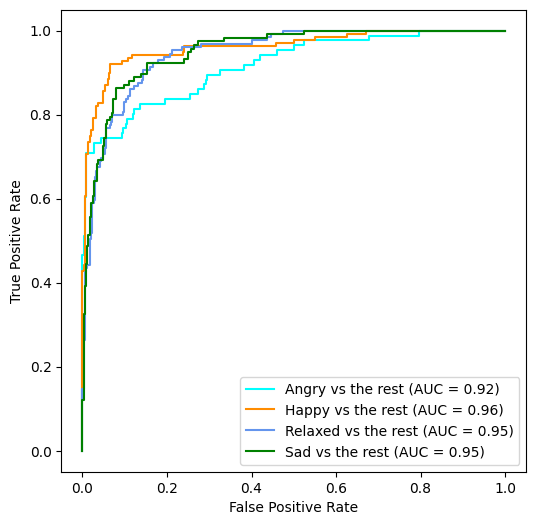

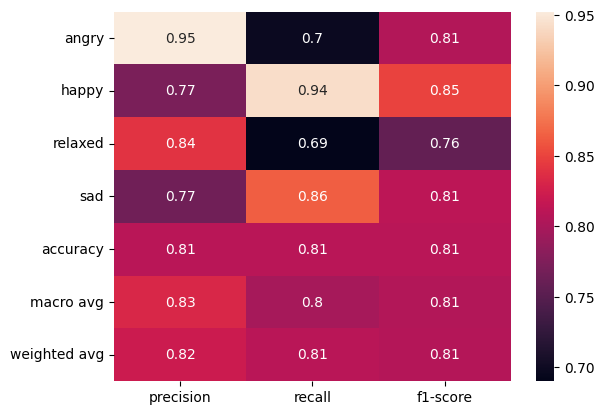

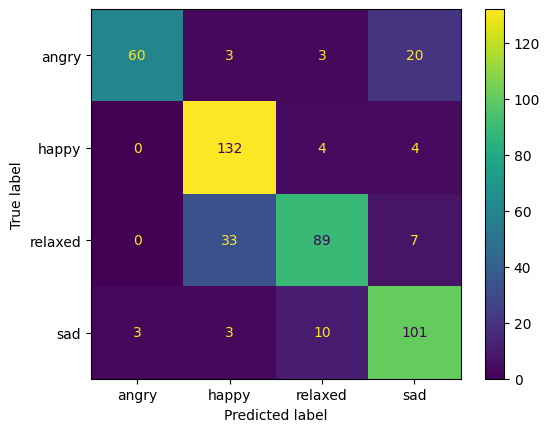

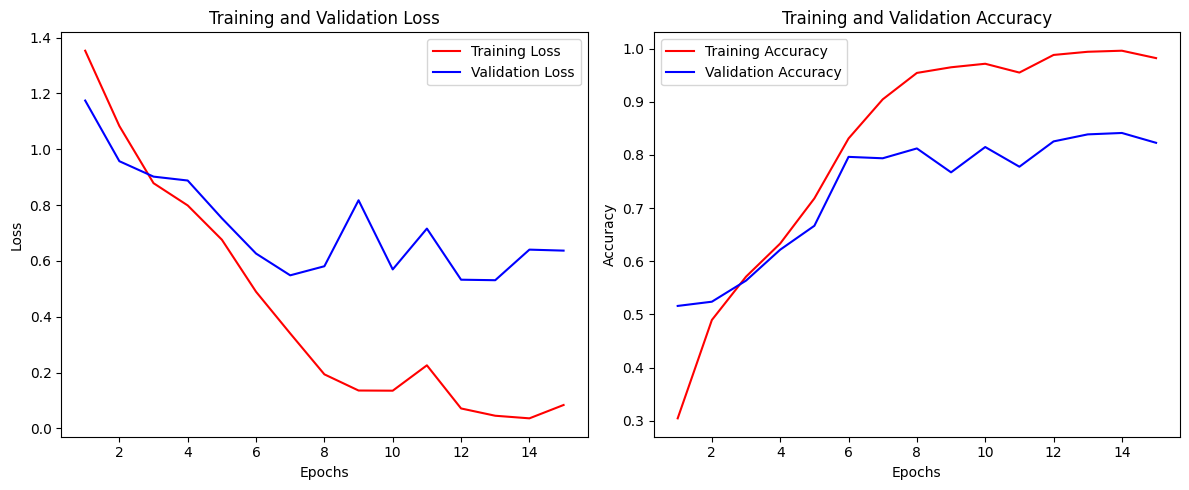

In [ ]:
lstm = load_model(lstm_binary_path)
with open(lstm_history_path, "rb") as file:
    history = pickle.load(file)

evaluate_estimator(
    lstm, test_padseq, np.argmax(y_test, axis=1), preds_one_hot=True, history=history
)